In [1]:
#pip install ipython-autotime
%load_ext autotime

time: 2.74 ms (started: 2021-04-16 02:24:42 +00:00)


# Import from Google Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
ls drive/MyDrive/SpringBoard/'Sample Projects'/Amazon/Electronics

Amazon_electronics.csv    Amazon_electronics_kaggle_files/
Amazon_electronics.ipynb  Amazon_electronics_kaggle.html


In [8]:
%cd "drive/MyDrive/SpringBoard/Sample Projects/Amazon/Electronics"

/content/drive/MyDrive/SpringBoard/Sample Projects/Amazon/Electronics


# Types of recommenders

---

[Types of Recommenders](https://miro.medium.com/max/1064/1*mz9tzP1LjPBhmiWXeHyQkQ.png)

[Types of Recommendation System Methods](https://blog.codecentric.de/files/2019/06/Fig1-1.png)

Simple recommenders

*   offer generalized recommendations to every user, based on movie popularity and/or genre. The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience. An example could be IMDB Top 250.

Content-based recommenders

*   suggest similar items based on a particular item. This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make these recommendations. The general idea behind these recommender systems is that if a person likes a particular item, he or she will also like an item that is similar to it. And to recommend that, it will make use of the user's past item metadata. A good example could be YouTube, where based on your history, it suggests you new videos that you could potentially watch.

Collaborative filtering engines

*   these systems are widely used, and they try to predict the rating or preference that a user would give an item-based on past ratings and preferences of other users. Collaborative filters do not require item metadata like its content-based counterparts.

Source: datacamp.com/community/tutorials/recommender-systems-python

# Import necessary libraries and data

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
df = pd.read_csv('Amazon_electronics.csv', names=['user_id','product_id','ratings','timestamp'])

## Checking out dataframe

In [7]:
print(df.shape)
df.head()

(7824482, 4)


,user_id,product_id,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


time: 29.5 ms (started: 2021-04-16 02:24:53 +00:00)


In [8]:
# Checking out shape, dtypes, and null values of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   user_id     object 
 1   product_id  object 
 2   ratings     float64
 3   timestamp   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB
time: 15.1 ms (started: 2021-04-16 02:24:53 +00:00)


## Dtype conversion

It looks like the data have been masked, so I decided to change those ids into categorical codes that pleases my eyes.

In [9]:
# Converting to appropriate dtypes
df['user_code'] = df['user_id'].astype('category').cat.codes
df['product_code'] = df['product_id'].astype('category').cat.codes
df['user_code'] = df['user_code'].astype('category')
df['product_code'] = df['product_code'].astype('category')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df['ratings'] = df['ratings'].astype('int64')

time: 31.1 s (started: 2021-04-16 02:24:53 +00:00)


## Glance at unique value counts by columns

In [10]:
cols = df[df.columns[0:2]]
for i in cols:
  a = df[i].value_counts()
  print('{}'.format(a))

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
                 ... 
A529OHE4QVPZN       1
A2MO5GWRX48POV      1
A2V0U3ZE8YQOFM      1
A22BZ0KOUAQ3PU      1
A2O8FORT0E0FDS      1
Name: user_id, Length: 4201696, dtype: int64
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
              ...  
B003M5MAVW        1
B004BQUJZ0        1
B007CJQ3BC        1
B00AF1J1IQ        1
B001JT0KK6        1
Name: product_id, Length: 476002, dtype: int64
time: 11.2 s (started: 2021-04-16 02:25:24 +00:00)


There are 4201696 unique users and 476002 unique products in this dataframe.

## Calibrating popularity score

In [11]:
# Calculating the average ratings of each product
df.groupby('product_id')['ratings'].mean().sort_values(ascending=False)
# Getting count of # of ratings given to products. 
# This will help in removing unwanted bias cases whereby a product gets a high rating score with a single high rating review.
df.groupby('product_id')['ratings'].count().sort_values(ascending=False)
df['ratings_mean'] = df.groupby('product_id')['ratings'].transform('mean')
df['ratings_count'] = df.groupby('product_id')['ratings'].transform('count')

time: 3.75 s (started: 2021-04-16 02:25:35 +00:00)


In [12]:
# Get an statistics overview on numerical data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ratings,7824482.0,4.012337,1.380910,1.0,3.000000,5.000000,5.00000,5.0
ratings_mean,7824482.0,4.012337,0.611508,1.0,3.714286,4.131257,4.42735,5.0
ratings_count,7824482.0,789.154791,1984.079023,1.0,32.000000,149.000000,602.00000,18244.0


time: 1.44 s (started: 2021-04-16 02:25:39 +00:00)


In [13]:
df_01 = df[['user_code','product_code','ratings','ratings_mean','ratings_count','timestamp']]
df_01.head()

,user_code,product_code,ratings,ratings_mean,ratings_count,timestamp
0,3728515,0,5,5.000000,1,2013-04-13
1,1512496,1,5,5.000000,1,2012-07-01
2,1850798,2,1,1.666667,3,2013-04-29
3,2118940,2,3,1.666667,3,2013-07-22
4,511952,2,1,1.666667,3,2012-04-18


time: 105 ms (started: 2021-04-16 02:25:40 +00:00)


## Testing out best column to groupby

In [14]:
df_01.set_index(['product_code','user_code'])

ratings  ratings_mean  ratings_count  timestamp
product_code user_code                                                 
0            3728515          5      5.000000              1 2013-04-13
1            1512496          5      5.000000              1 2012-07-01
2            1850798          1      1.666667              3 2013-04-29
             2118940          3      1.666667              3 2013-07-22
             511952           1      1.666667              3 2012-04-18
...                         ...           ...            ...        ...
476000       2190980          5      4.000000             15 2014-04-04
             2286114          5      4.000000             15 2011-08-15
             696708           4      4.000000             15 2014-07-01
             23664            4      4.000000             15 2011-02-13
476001       1614235          5      5.000000              1 2011-08-07

[7824482 rows x 4 columns]

time: 2.03 s (started: 2021-04-16 02:25:40 +00:00)


In [15]:
df_01.set_index(['user_code','product_code'])

,,ratings,ratings_mean,ratings_count,timestamp
user_code,product_code,,,,
3728515,0,5,5.000000,1,2013-04-13
1512496,1,5,5.000000,1,2012-07-01
1850798,2,1,1.666667,3,2013-04-29
2118940,2,3,1.666667,3,2013-07-22
511952,2,1,1.666667,3,2012-04-18
...,...,...,...,...,...
2190980,476000,5,4.000000,15,2014-04-04
2286114,476000,5,4.000000,15,2011-08-15
696708,476000,4,4.000000,15,2014-07-01


time: 1.67 s (started: 2021-04-16 02:25:42 +00:00)


## Ratings distribution

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


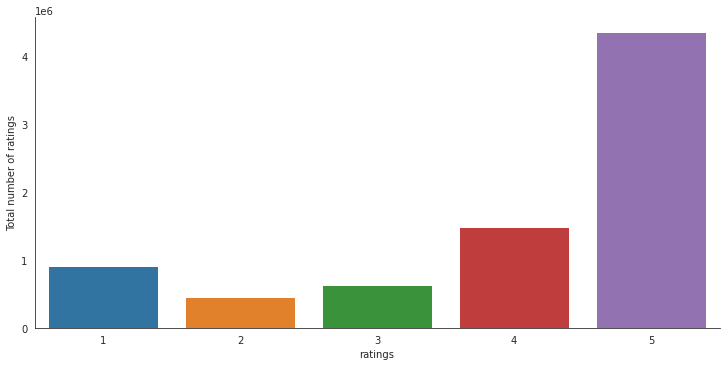

time: 34.2 s (started: 2021-04-16 02:25:44 +00:00)


In [16]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("ratings", data=df_01, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

Text(0, 0.5, 'Ratings count')

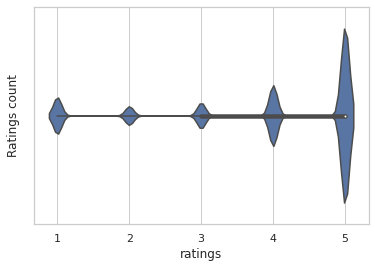

time: 26.2 s (started: 2021-04-16 02:26:18 +00:00)


In [17]:
sns.set_theme(style="whitegrid")
ax = sns.violinplot(x='ratings', data=df)
ax.set_ylabel('Ratings count')

The graph above shows the distributions of ratings given to products. It seems that most of the products sold have a positive response from users with almost 4.5 million ratings, while ratings 4 and below have less than 2 million ratings.

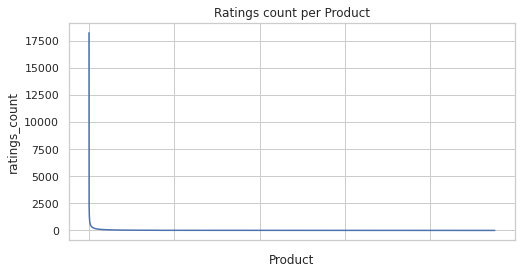

time: 473 ms (started: 2021-04-16 02:26:44 +00:00)


In [18]:
ratings_count = df_01.groupby(by='product_code')['ratings'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(ratings_count.values)
plt.title('Ratings count per Product')
plt.xlabel('Product')
plt.ylabel('ratings_count')
ax.set_xticklabels([])

plt.show()

Text(0, 0.5, 'users / ratings_count')

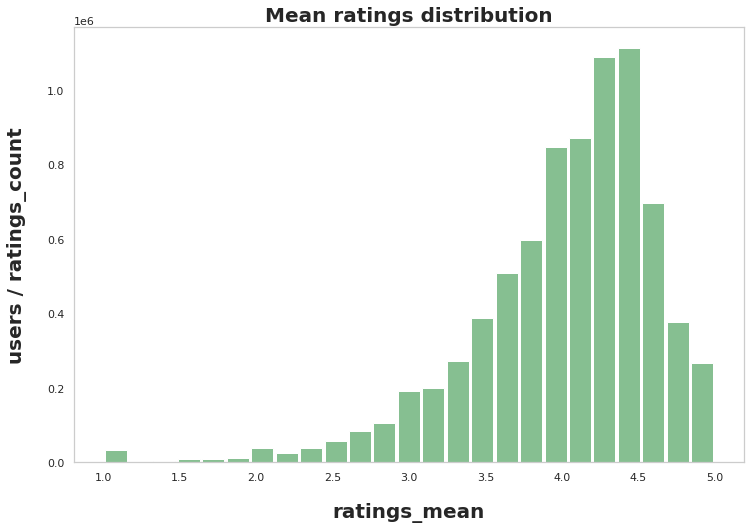

time: 764 ms (started: 2021-04-16 02:26:45 +00:00)


In [19]:
df_01.hist(column='ratings_mean', bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

plt.title('Mean ratings distribution', weight='bold', fontsize=20)
plt.xlabel("ratings_mean", labelpad=20, weight='bold', size=20)
plt.ylabel("users / ratings_count", labelpad=20, weight='bold', size=20)

Before analyzing this graph, lets assume that a high rating means the user likes the product because the product is good and a low rating means the user is unhappy about the product because it is either bad or not what the user expects. With this assumption in mind, this graph could be deduced in a few ways.
*   The first being the products sold are just that good, therefore the feedback from customers are mostly positive.
*   The second being that users have a tendency to give ratings to products that are good while neglecting products that are bad.

For this analysis, I will assume the former case to be the true case.


The graph is skewed as the total number of products are close to four million, while the number of ratings per product is very few.

<Figure size 576x432 with 0 Axes>

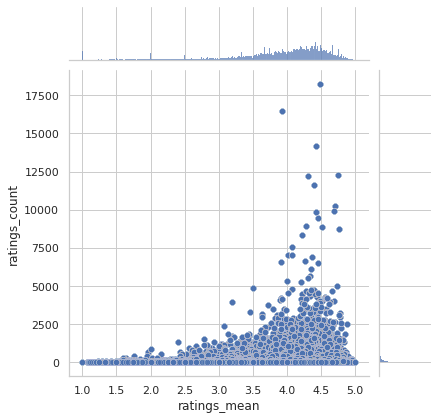

time: 39.2 s (started: 2021-04-16 02:26:46 +00:00)


In [20]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='ratings_mean', y='ratings_count', data=df, alpha=0.1)

The graph above clearly shows that the higher the rating average of a product, the higher the number of ratings given to a product. This implies that people tend to give ratings to products that they like and not products that they dislike which leads to the data skewed towards the higher rating side.

# Simple Recommender - 90th precentile

In [21]:
# Ratings df groupby products
df_rating=pd.DataFrame({'Ratings_count':df.groupby('product_id').count()['ratings'], 'Ratings_mean':df.groupby('product_id').mean()['ratings']})

# Determining cutoff point
cutoff = df_rating['Ratings_count'].quantile(q=0.9)
print('Ratings count cutoff point: {}'.format(cutoff))

df_trim = df_rating[df_rating['Ratings_count'] > cutoff]
print(df_trim.shape)
df_trim.head(2)

Ratings count cutoff point: 25.0
(46553, 2)


,Ratings_count,Ratings_mean
product_id,,
0528881469,27,2.851852
0594481813,31,4.225806


time: 2.88 s (started: 2021-04-16 02:27:25 +00:00)


In [22]:
# Creating weighted average function
def product_score(x):
    aa=x['Ratings_count']
    ab=df_rating['Ratings_count'].quantile(q=0.9)
    bb=x['Ratings_mean']
    bc=df_rating['Ratings_mean'].mean()
    return ((bb*aa)/(aa+ab))+((bc*ab)/(aa+ab))

time: 4.83 ms (started: 2021-04-16 02:27:28 +00:00)


In [23]:
df_trim['score'] = df_trim.apply(product_score, axis=1)
df_trim.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Ratings_count,Ratings_mean,score
product_id,,,
0528881469,27,2.851852,3.350817
0594481813,31,4.225806,4.075759


time: 8min 56s (started: 2021-04-16 02:27:28 +00:00)


In [24]:
# Top 10 most popular product
df_trim.sort_values('score', ascending=False).head(10)

,Ratings_count,Ratings_mean,score
product_id,,,
B0043WJRRS,2512,4.881369,4.871597
B00CG70K78,237,4.949367,4.848254
B007SZ0E1K,449,4.895323,4.842284
B003FVVMS0,1876,4.853412,4.840738
B0033PRWSW,387,4.901809,4.840394
B008VGCT9K,230,4.939130,4.836245
B0029N3U8K,658,4.869301,4.833444
B0041OYTJE,458,4.879913,4.828659
B00GMRCAC6,187,4.951872,4.826616


time: 30.9 ms (started: 2021-04-16 02:36:25 +00:00)


### Visual

Text(0, 0.5, '# of users')

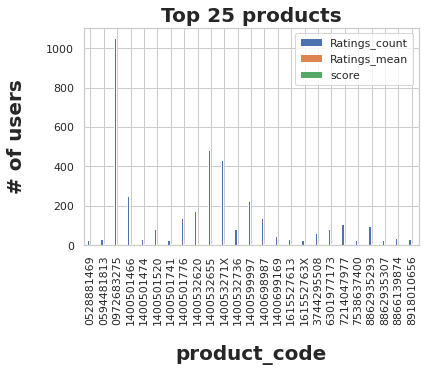

time: 634 ms (started: 2021-04-16 02:36:25 +00:00)


In [25]:
df_trim.head(25).plot(kind='bar')
plt.title('Top 25 products', weight='bold', fontsize=20)
plt.xlabel("product_code", labelpad=20, weight='bold', size=20)
plt.ylabel("# of users", labelpad=20, weight='bold', size=20)

Since the initial data was masked (anonymized), I can only show the product_id. This is a simple recommender using popularity of a product as recommendation system. If given more data features such as category, price, location etc, a further step could be taken to increase the accuracy of recommender. This type of recommender is very general and not personalized per user's preferences or habits.

# Collaborative Recommender: SVD

In [3]:
from surprise import SVD, Reader, Dataset 
from surprise.model_selection import cross_validate

In [11]:
df.head()

,user_id,product_id,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [12]:
df_00 = df[['user_id','product_id','ratings']]

svd = SVD()
reader = Reader()

In [13]:
data = Dataset.load_from_df(df_00, reader)

In [14]:
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2949  1.2945  1.2933  1.2941  1.2950  1.2944  0.0006  
MAE (testset)     1.0191  1.0186  1.0180  1.0191  1.0193  1.0188  0.0004  
Fit time          486.03  501.60  492.45  501.90  500.93  496.58  6.34    
Test time         26.48   17.56   26.42   17.88   22.02   22.07   3.90    


{'fit_time': (486.0301196575165,
  501.60488390922546,
  492.4515850543976,
  501.90462923049927,
  500.9286239147186),
 'test_mae': array([1.0190874 , 1.01860339, 1.01803746, 1.01908614, 1.01927688]),
 'test_rmse': array([1.29486523, 1.29454054, 1.29326861, 1.29409016, 1.29501048]),
 'test_time': (26.477362394332886,
  17.564444303512573,
  26.416104316711426,
  17.87590479850769,
  22.017778396606445)}

In [15]:
trainset = data.build_full_trainset()
svd.fit(trainset)

## Random user selection

In [16]:
# Selects a random user for test purposes
test_user = df['user_id'].sample().to_list()
test_list = df[df['user_id'] == test_user[0]]
test_product = test_list['product_id'].tolist()
product_rating = test_list['ratings'].tolist()
print('Test user id: {}'.format(test_user[0]),'\n'
  'Test product id: {}'.format(test_product[0]),'\n'
  'Test product rating: {}'.format(product_rating[0]))

Test user id: A3HIWOAI6SGXQL 
Test product id: B0000DYV9H 
Test product rating: 5.0


## Prediction on product rated by random user

In [17]:
# Predicting ratings for test user on test product
prediction = svd.predict(uid=test_user[0], iid=test_product[0]).est
print('Rating prediction: {}'.format(prediction))

Rating prediction: 4.913724906324422


## Rating prediction difference

In [18]:
# Actual vs prediction ratings percentage difference
diff = np.diff(np.array([product_rating[0], prediction]))
diff_per = np.divide(diff, product_rating[0])
print('Ratings difference: {}'.format(diff[0]),'\n'
  'Rating % difference: {}'.format(diff_per[0]))

Ratings difference: -0.08627509367557806 
Rating % difference: -0.01725501873511561


The rating prediction looks to be fairly accurate for this particular set of user and product.